In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/total_cpi_MinMaxScaler.csv')
df['ds'] = pd.to_datetime(df['ds'])

df = df.reset_index().rename(columns={'index': 'unique_id', 'ws': 'y'})
df['unique_id'] = df['unique_id'].apply(lambda x: '0')

end_train_start_test = int(len(df) * .85)
train_index, test_index = range(end_train_start_test), range(end_train_start_test, len(df))
Y_train_df, Y_test_df = df.iloc[train_index], df.iloc[test_index].reset_index(drop=True)

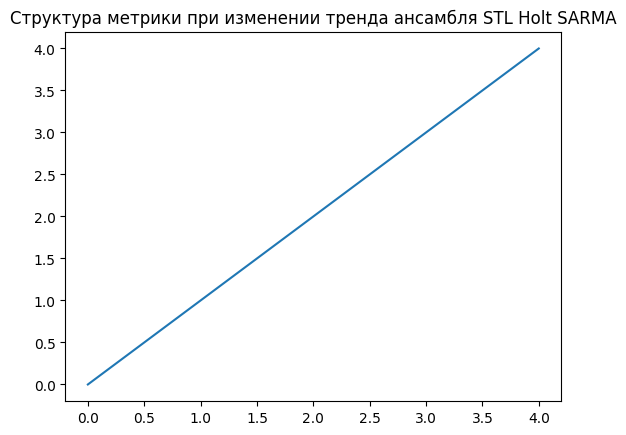

In [2]:
plt.plot(range(5))
plt.title('Структура метрики при изменении тренда ансамбля STL Holt SARMA')
plt.show()

## Compare forecast

In [ ]:
df_forecast = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')
df_forecast.ds = pd.to_datetime(df_forecast.ds)


In [ ]:
df_forecast.columns

Index(['Unnamed: 0.8', 'Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5',
       'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'unique_id', 'ds', 'NBEATS', 'NHITS', 'HW',
       'XGBRegressor', 'SARIMA', 'STL_H_SNaive_mean', 'STL_H_SNaive_exp',
       'STL_H_SARIMA', 'SVD_HW', 'SVD_HW_weights', 'SVD_SARIMA',
       'SVD_SARIMA_weights'],
      dtype='object')

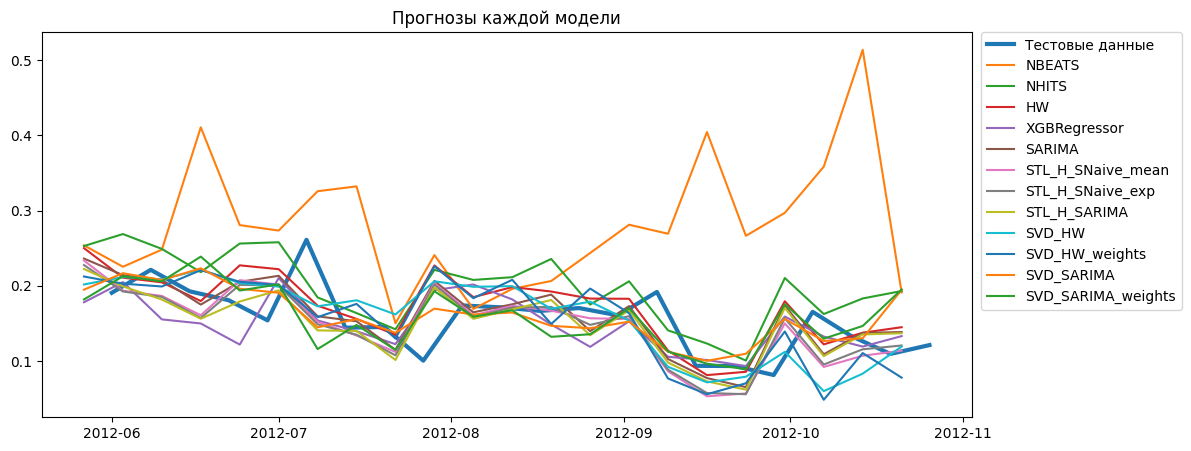

In [ ]:
plt.figure(figsize=(12, 5))

columns_forecast = df_forecast.columns[13:]
plt.plot(Y_test_df.ds, Y_test_df.y, label='Тестовые данные', linewidth=3)
for clm in columns_forecast:
    plt.plot(df_forecast.ds, df_forecast[clm], label=clm)

# Добавляем легенду за пределами графика (справа)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.title('Прогнозы каждой модели')

# Увеличиваем пространство справа от графика, чтобы легенда не перекрывала его
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # параметры rect регулируют область графика

plt.show()

In [ ]:
def metric_series(true, predict, step=1, metric=mean_absolute_error):
  return [
      metric(true.iloc[:i], predict.iloc[:i]) * (100 if metric == mean_absolute_percentage_error else 1)
      for i in range(step, true.shape[0], step)
  ]

def metric_df(true, df_predict, step=1, metric=mean_absolute_error):
  return [
      metric_series(true, df_predict[column], step, metric)
      for column in df_predict.columns
  ]

def build_plot(name_metric='MAE', metric_calc=mean_absolute_error, step=1):
  metrics = metric_df(Y_test_df.y, df_forecast[columns_forecast], step, metric_calc)
  plt.figure(figsize=(12, 5))

  for i, metric in enumerate(metrics):
    plt.plot(range(step, Y_test_df.shape[0], step), metric, label=columns_forecast[i], marker='o')

  plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
  plt.ylabel(name_metric)
  plt.xlabel('Дальность прогноза')
  plt.title('Изменение ошибки в зависимости от горизонта прогноза')
  plt.grid()
  plt.show()

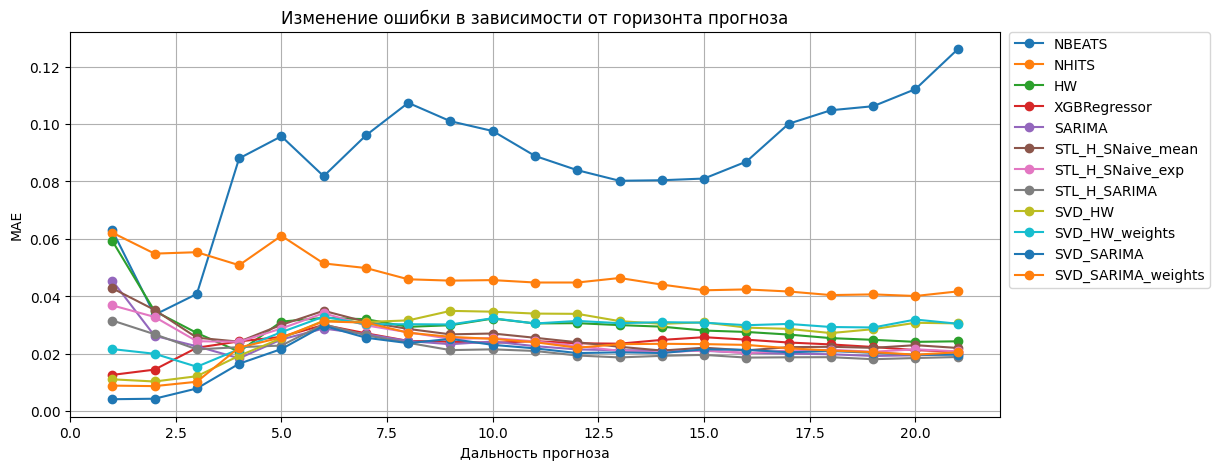

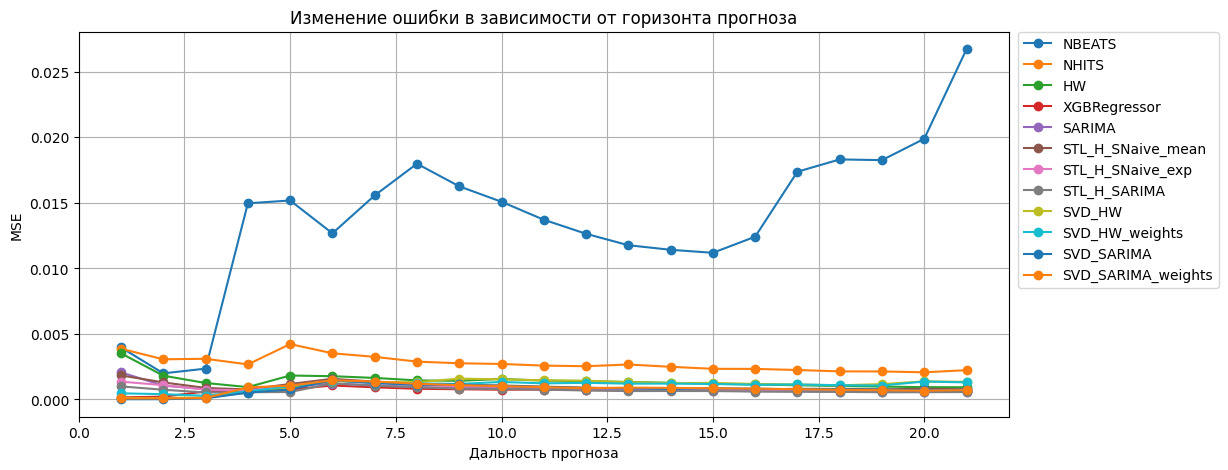

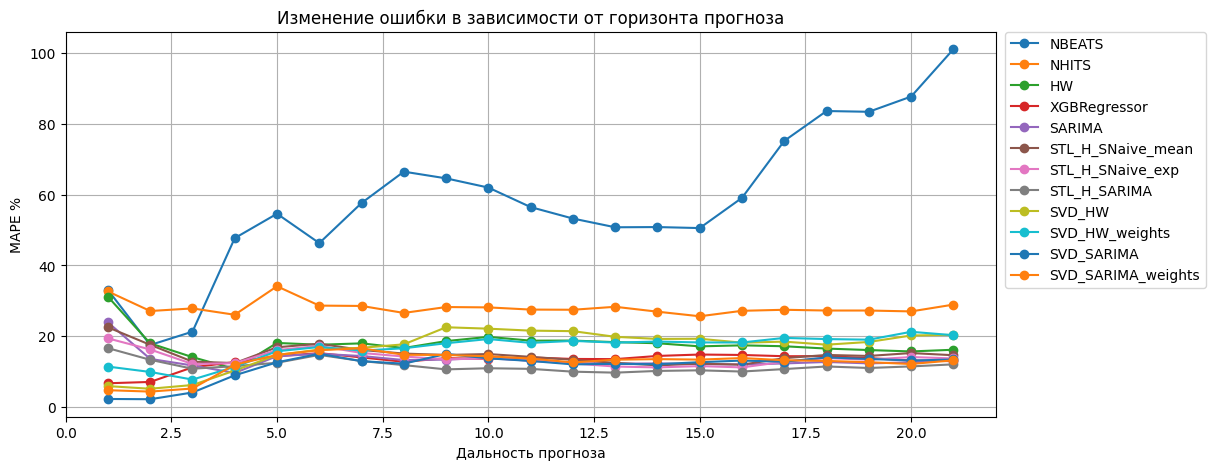

In [ ]:
build_plot()
build_plot('MSE', mean_squared_error)
build_plot('MAPE %', mean_absolute_percentage_error)

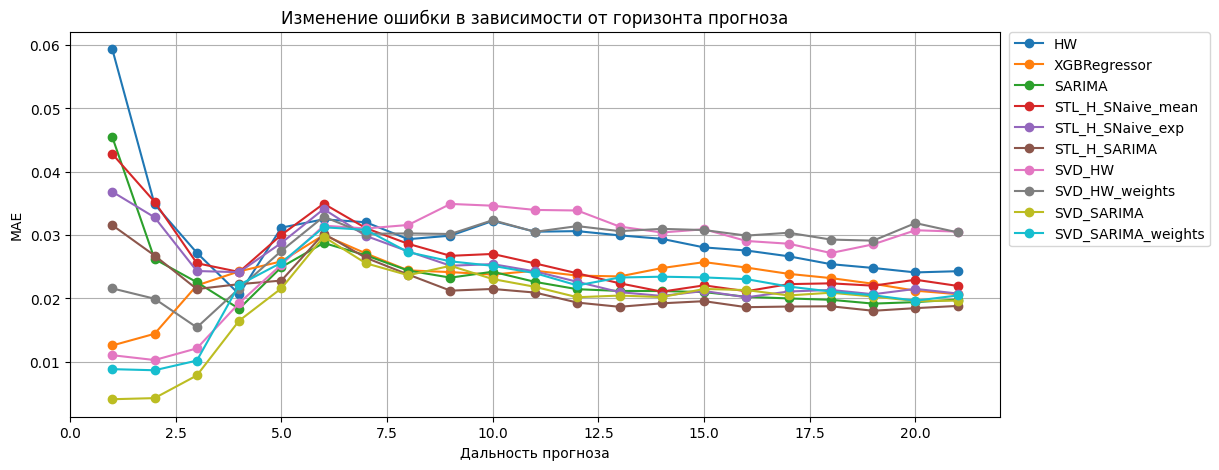

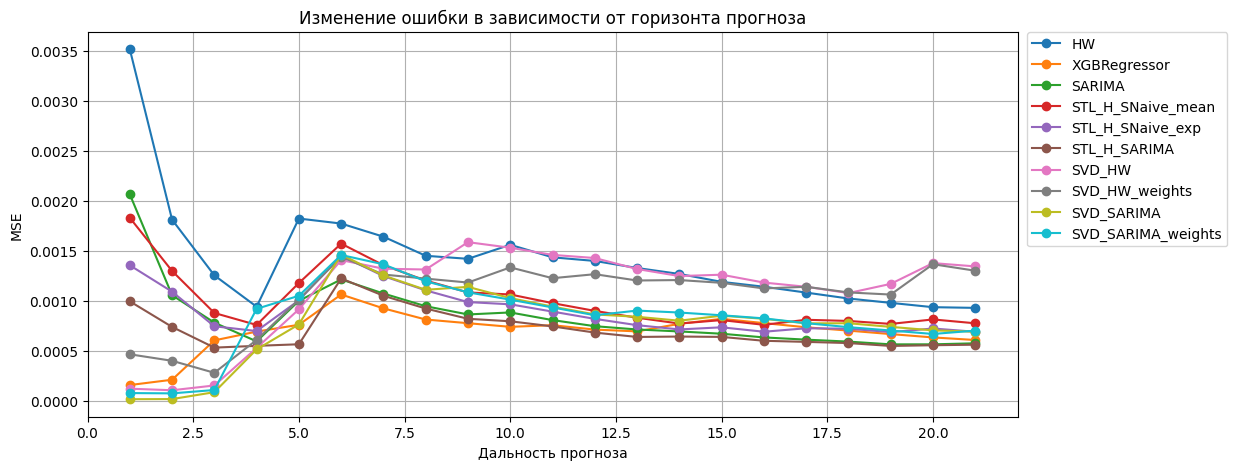

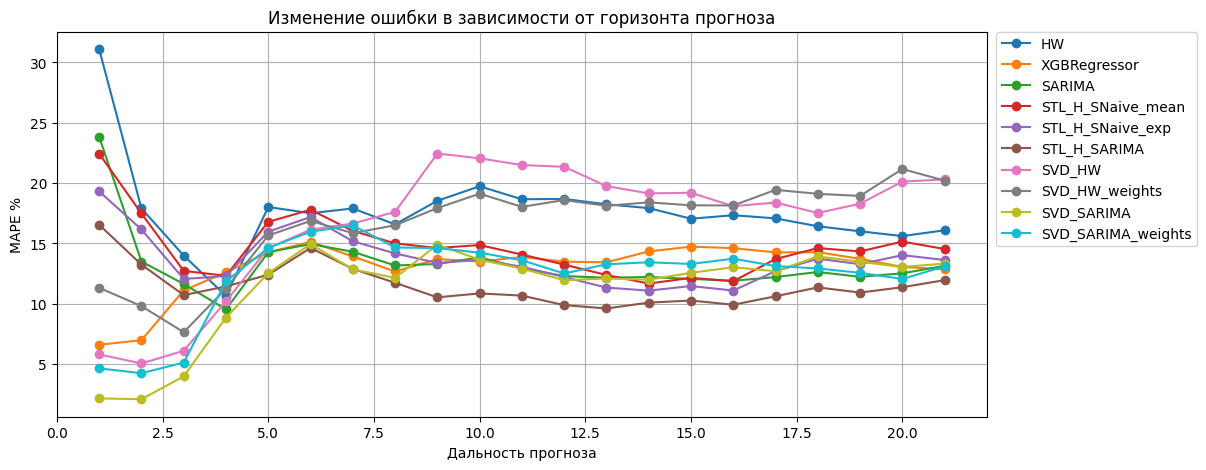

In [ ]:
def build_plot(name_metric='MAE', metric_calc=mean_absolute_error, step=1):
  metrics = metric_df(Y_test_df.y, df_forecast[columns_forecast[2:]], step, metric_calc)
  plt.figure(figsize=(12, 5))

  for i, metric in enumerate(metrics):
    plt.plot(range(step, Y_test_df.shape[0], step), metric, label=columns_forecast[i+2], marker='o')

  plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
  plt.ylabel(name_metric)
  plt.xlabel('Дальность прогноза')
  plt.title('Изменение ошибки в зависимости от горизонта прогноза')
  plt.grid()
  plt.show()

build_plot()
build_plot('MSE', mean_squared_error)
build_plot('MAPE %', mean_absolute_percentage_error)

In [ ]:
mean_absolute_percentage_error([100], [60])

0.4

## library

In [ ]:
from numpy.typing import NDArray
import math as mt
import itertools

### Show

In [ ]:
class BaseError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def shapeError(*args):
    for i in range(2, len(args) - 1):
      assert args[i].shape == args[i + 1].shape, BaseError(f'x and y must have same first dimension, {args[i].shape} and {args[i + 1].shape}')


class SubplotError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def all_arg_one_type(*args):
    types = set([type(arg) for arg in args[1:]])
    assert len(types) == 1, SubplotError(f'Arguments don`t have one type')

  @classmethod
  def shapeError(*args):
    BaseError.shapeError(*args)


class Show():
    def __init__(self, base_figsize=(5, 2)) -> None:
        self.fig, self.axes = None, None
        self.shape, self.pos = None, [0, 0]
        self.base_figsize = base_figsize  # базовый размер для одного подграфика

    def create_subplot(self, nrows: int, ncols: int) -> None:
        self.shape = [nrows, ncols]
        # Автоматический расчет размера фигуры на основе количества подграфиков
        fig_width = self.base_figsize[0] * ncols
        fig_height = self.base_figsize[1] * nrows
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

    def add_subplot(self, xvalue: NDArray, yvalue: NDArray, **kwargs):
        if self.shape[0] == 1 and self.shape[1] == 1:
            self.axes.plot(xvalue, yvalue, **kwargs)
        elif self.shape[0] == 1 or self.shape[1] == 1:
            self.axes[self.pos[0] if self.shape[0] > 1 else self.pos[1]].plot(xvalue, yvalue, **kwargs)
        else:
            self.axes[self.pos[0], self.pos[1]].plot(xvalue, yvalue, **kwargs)

        if self.pos[1] + 1 < self.shape[1]:
            self.pos[1] += 1
        else:
            self.pos[0] += 1
            self.pos[1] = 0

    def subplot(self, xvalues: NDArray, yvalues: NDArray, nrows: int, ncols: int):
        SubplotError.shapeError(xvalues, yvalues)
        self.create_subplot(nrows, ncols)

        for i in range(xvalues.shape[0]):
            self.add_subplot(xvalues[i], yvalues[i])

        plt.subplots_adjust(wspace=0.3, hspace=0.2)
        plt.show()

    def subplot_x(self, yvalues: NDArray, ncols: int) -> None:
        xvalues = [np.arange(yvalues.shape[1])] * yvalues.shape[0]
        nrows = mt.ceil(yvalues.shape[0] / ncols)
        self.subplot(np.array(xvalues), yvalues, nrows, ncols)

    def one_plot(self, y: NDArray, labels: NDArray, x: NDArray = None, title: str = None) -> None:
        if x is None:
          x = np.array([np.arange(y.shape[1])] * y.shape[0])

        SubplotError.shapeError(x, y)

        for i, yv in enumerate(y):
          plt.plot(x[i], yv, label=labels[i])

        if title:
          plt.title(title)
        plt.legend()
        plt.show()

### GenerateData Analytics

In [ ]:
class GenerateDataError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def other_ts(*args):
    for i in range(1, len(args[1:]) - 1):
      assert (args[i].ts != args[i + 1].ts).sum(), GenerateDataError('Diferent time series')

  @classmethod
  def add_error(cls):
    raise GenerateDataError('Error add')

  @classmethod
  def init_param(cls, ts, change, data):
    assert data is not None or (ts is not None and change is not None), GenerateDataError('data or (ts and change) can be not None')


class GenerateData():
  def __init__(self, ts: NDArray = None, change: NDArray = None,  data=None, method: str = 'additive') -> None:
    GenerateDataError.init_param(ts, change, data)
    self.data = data
    if change is not None and ts is not None:
       if method == 'additive':
         self.data = self.additive_date(ts, change)

  def __add__(self, other):
    if isinstance(other, GenerateData):
      GenerateDataError.other_ts(self, other)
      data = np.vstack((self.data, other.data))
      return GenerateData(data=data)
    else:
      GenerateDataError.add_error()

  def additive_date(self, ts: NDArray, change: NDArray):
    ready = [ts + ch for ch in change]
    return np.array(ready)


class Analytics():
  def __init__(self, data: GenerateData, title: NDArray = None) -> None:
     self.title = title
     self.data = data

  def correlogram_compare(self, lags=52, alpha=.05, figsize=(12, 6)) -> None:
    nrows = self.data.shape[0]
    figsize = (figsize[0], figsize[1] * nrows / 3)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
    axes = axes.ravel()
    i_axes = 0

    for i in range(self.data.shape[0]):
      plot_acf(self.data[i],
               lags=lags,
               ax=axes[i_axes],
               alpha=alpha,
               title=f'ACF {self.title[i] if self.title is not None else ""}',
               zero=False)
      plot_pacf(self.data[i],
                lags=lags,
                alpha=alpha,
                ax=axes[i_axes + 1],
                title=f'PACF {self.title[i] if self.title is not None else ""}',
                zero=False)
      i_axes += 2

    # Настройка общего заголовка
    plt.suptitle(f'Correlograms for Time Series Analysis (α={alpha})', y=1.02)
    plt.tight_layout()
    plt.show()

  def correlogram_compare_one(self, lags=52, alpha=.05, figsize=(12, 6)) -> None:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    for i in range(self.data.shape[0]):
      plot_acf(self.data[i],
               lags=lags,
               ax=ax1,
               alpha=alpha,
               title=f'ACF',
               zero=False)
      plot_pacf(self.data[i],
                lags=lags,
                alpha=alpha,
                ax=ax2,
                title=f'PACF',
                zero=False)

    plt.suptitle(f'Correlograms for Time Series Analysis (α={alpha})', y=1.02)
    plt.tight_layout()
    plt.show()

  def plot_ts(self) -> None:
    show = Show()
    show.subplot_x(self.data, 2)

### Split HWCompare

In [ ]:
class SplitTrainTestError(Exception):
  def __init(self, message):
    super().__init__(message)

  def half(half):
    assert half >= 0 and half <= 1, SplitTrainTestError(f'The half can be belongs to the interval [0, 1]')


class SplitTrainTest():
  def __init__(self, data: GenerateData, half: float | int):
    SplitTrainTestError.half(half)

    self.half = half
    self.data_original = data
    self.train_index, self.test_index = self.__get_split_index(self.data_original.shape[1])
    self.data_split = None

  def __get_split_index(self, len):
    end_train_start_test = int(len * self.half)
    return np.arange(0, end_train_start_test), np.arange(end_train_start_test, len)

  def split(self):
    new_data = [[dt[self.train_index], dt[self.test_index]] for dt in self.data_original]
    self.data_split = new_data
    return self.data_split

  def split_use_signs(self, df_sings):
    self.split()
    x_train, x_test = df_sings.iloc[self.train_index], df_sings.iloc[self.test_index]
    return (x_train, x_test, self.data_split)


class ModelCompare():
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str, columns, step_lf: int):
    self.params = []

    self.split = SplitTrainTest(gd.data, .85)
    self.data = self.split.data_split
    self.name = name
    self.df_path = df_path
    self.df_path_long_forecast = df_path_long_forecast
    self.df = pd.DataFrame(columns=columns)

    if self.df_path_long_forecast is not None:
      self.df_long_forecast = pd.DataFrame(columns=[f'{cl}' for cl in range(step_lf, self.split.test_index.size, step_lf)])


class HWCompare(ModelCompare):
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str = None, step_lf=3) -> None:
    columns=['name', 'trend', 'seasonal', 'period', 'aicc', 'bic', 'mae', 'mse']
    super().__init__(gd, name, df_path, df_path_long_forecast, columns, step_lf)
    self.data = self.split.split()

  def build_hw(self, i_data: int, trend: str, seasonal: str, seasonal_period: int):
    train = self.data[i_data][0]
    test = self.data[i_data][1]

    ses = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
    result = ses.fit()
    forecast = result.forecast(test.size)

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)

    self.df.loc[self.df.shape[0]] = [self.name[i_data], trend, seasonal, seasonal_period, result.aicc, result.bic, mae, mse]
    self.df.to_csv(self.df_path, index=False)

    if self.df_path_long_forecast is not None:
      self.long_forecast(result, test)

  def long_forecast(self, result, test):
    forecast = []
    for step in range(3, test.size, 3):
      fr = result.forecast(steps=step)
      mae = mean_absolute_error(test[:step], fr)
      mse = mean_squared_error(test[:step], fr)
      forecast.append((mae, mse))

    self.df_long_forecast.loc[self.df_long_forecast.shape[0]] = forecast
    self.df_long_forecast.to_csv(self.df_path_long_forecast, index=False)

  def compare(self, size_seasonal, period=[52]) -> None:
    trend = [None, 'add']
    seasonal = [None, 'add']

    print(f'All combinations {len(self.data[:-size_seasonal]) * 4 + size_seasonal * 4 * len(period)}')
    i_combination = 1

    for i_data in range(len(self.data)):
      for t in trend:
        for s in seasonal:
          if i_data < (len(self.data[:-size_seasonal])):
            print(f'cimbination {i_combination}')
            i_combination += 1
            self.build_hw(i_data, t, s, period[0])
          else:
            for p in period[1:]:
              print(f'cimbination {i_combination}, period {p}')
              i_combination += 1
              self.build_hw(i_data, t, s, p)


### BestParams

In [ ]:

class BestParams():
  def __init__(self):
    self.df = pd.DataFrame()
    self.df_long_forecast = pd.DataFrame()
    self.best_params = []

  def load(self, path_df, path_df_lf=None):
    self.df = pd.read_csv(path_df)
    if path_df_lf:
      self.df_long_forecast = pd.read_csv(path_df_lf)

  def get_best_params(self, columns_params, sort_by):
    best_params = []
    for name in self.df['name'].unique():
      dff = self.df[self.df['name'] == name]
      dffs = dff.sort_values(by=sort_by, ascending=[True, True]).iloc[0]  # сортируем и берем первую строку
      params = {clp: dffs[clp] for clp in columns_params}
      best_params.append(params)
    return best_params

  def search_best_params(self, columns_params, sort_by=['aicc', 'bic']):
    best_params = self.get_best_params(columns_params, sort_by=sort_by)
    for bp in best_params:
      self.best_params.append(list(bp.values()))
    return self.best_params

  def print(self):
    for bp in self.best_params:
      for i, b in enumerate(bp):
        if i == 0:
          print('[', end='')
        print(b, end='')
        if i == len(bp) - 1:
          print(']')
        else:
          print(', ', end='')

  def __args_plot(self, bp, type_ts, inf_cr, name):
    information_cr, title, labels, x = [[] for _ in range(len(inf_cr))], [], [], []
    for b_dict in bp:
      if type_ts in b_dict[name]:
        for i, cr in enumerate(inf_cr):
          information_cr[i].append(b_dict[cr])


        fb_dict_key = [
            key
            for key in b_dict.keys()
            if key not in [name] + inf_cr
        ]
        title.append((b_dict[k] for k in fb_dict_key))
        x.append(float(b_dict[name].split(type_ts + '=')[-1]))

    for title_name in title:
      string = ''
      for tn in title_name:
        string += str(tn) + ' '
      labels.append(string)
    return information_cr, labels, x

  def plot(self, columns_params, type_ts=['k', 'alpha', 'freq'], inf_cr=['aicc', 'bic'], sort_by=['aicc', 'bic'], name='name', show_labels=False):
    bp = self.get_best_params(columns_params, sort_by=sort_by)
    for t in type_ts:
      information_cr, labels, x = self.__args_plot(bp, t, inf_cr, name)

      for i, cr in enumerate(inf_cr):
        plt.plot(x, information_cr[i], marker='o', label=cr.upper())
      plt.legend()
      plt.title('line trend' if t == 'k' else 'exp trend' if t == 'alpha' else 'sin seasonal')
      if show_labels:
        plt.xticks(x, labels, rotation=45)
      else:
        plt.xlabel(t)
      if len(inf_cr) == 1:
        plt.ylabel(inf_cr[0].upper())
      plt.show()


### GenerteComponents

In [ ]:
class GenerateComponents(GenerateData):
  def __init__(self, t: NDArray): # , data: NDArray = np.array([[]])
    # super().__init__(data=data)
    self.t = t

  def gen_line_trend(self, coefficient: NDArray, normalize=True):
    trend = np.array([k * self.t for k in coefficient])
    if normalize:
      trend = trend / trend.max()
    return GenerateData(data=trend)

  def gen_exp_trend(self, alphas: NDArray):
    n = self.t.shape[0]
    trend = []
    for alpha in alphas:
      trend.append([alpha ** (n - i) for i in range(1, n + 1)])

    trend = np.array(trend)
    return GenerateData(data=trend)

  def gen_seasonal(self, freq, coef=1, normalize=True):
    seasonal = np.array([np.sin(2 * np.pi * (1 / f) * self.t) for f in freq])
    if normalize:
      seasonal = seasonal + 1
      seasonal = seasonal / seasonal.max() * coef
    return GenerateData(data=seasonal)

  def generate_all(self, coefficient_lt, alpha_et, freq_s, coef_s):
    line_trend = self.gen_line_trend(coefficient_lt)
    exp_trend = self.gen_exp_trend(alpha_et)
    seasonal = self.gen_seasonal(freq_s, coef_s)
    return line_trend + exp_trend + seasonal

  def additive_components(self, components):
    if not len(components):
      return np.zero_like(t)
    for cmp in components[0]:
      self.additive_components(components[1:])


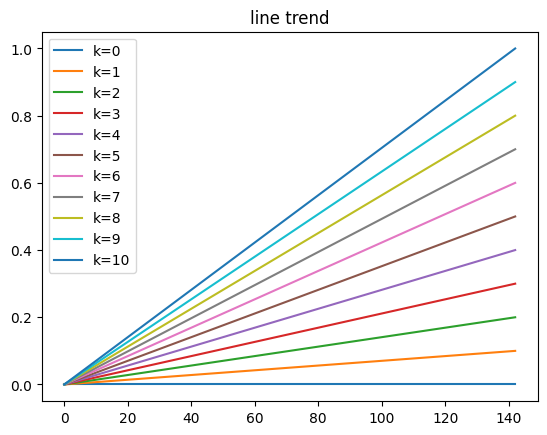

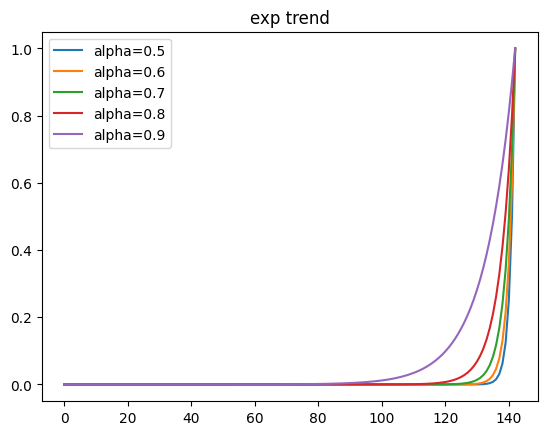

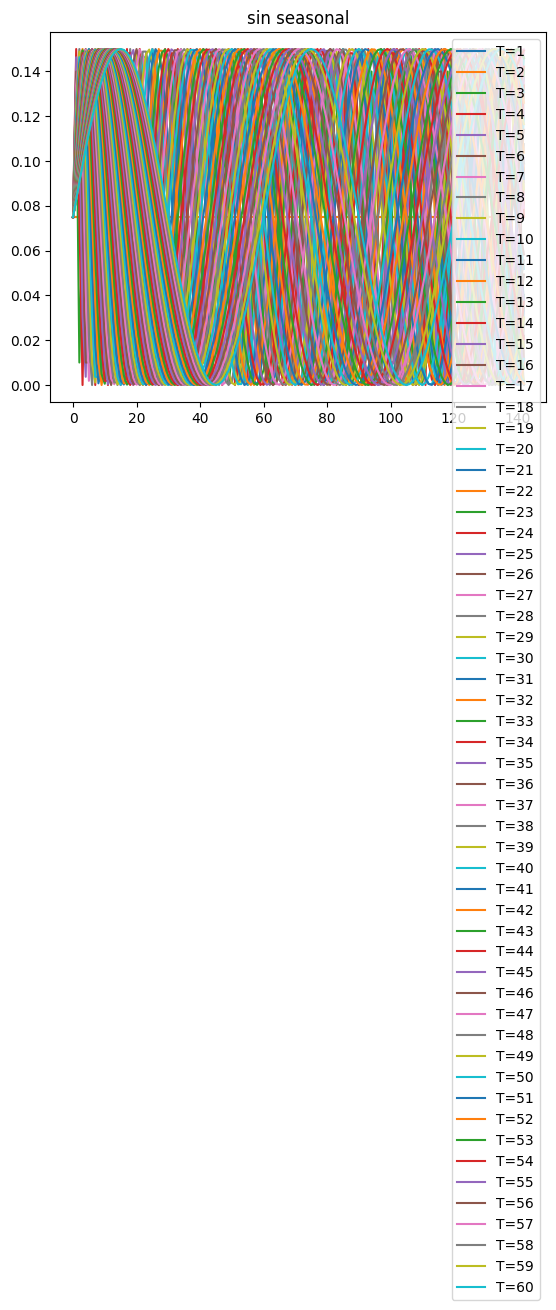

In [ ]:
t = np.arange(df.shape[0])
coefficient = np.arange(0, 11)
alphas = np.array([.5, .6, .7, .8, .9])
frequencies = np.arange(1, 61)

gc = GenerateComponents(t)
show = Show()

line_trend = gc.gen_line_trend(coefficient)
name_line_trend = [f'k={c}' for c in coefficient]
show.one_plot(line_trend.data, name_line_trend, title=f'line trend')

exp_trend = gc.gen_exp_trend(alphas)
name_exp_trend = [f'alpha={a}' for a in alphas]
show.one_plot(exp_trend.data, name_exp_trend, title=f'exp trend')


seasonal = gc.gen_seasonal(frequencies, .15)
name_seasonal = [f'T={f}' for f in frequencies]
show.one_plot(seasonal.data, name_seasonal, title='sin seasonal')

name = name_line_trend + name_exp_trend + name_seasonal

# name = []
# seasonals = None
# for i, coef in enumerate(coefs):
#   seasonal = gc.gen_seasonal(frequencies, coef)
#   name_s = [f'c={coef}, freq={f}' for f in frequencies]
#   if not i:
#     seasonals = seasonal
#   else:
#     seasonals = seasonals + seasonal
#   name += name_s
#   show.one_plot(seasonal.data, name_s, )

## code

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


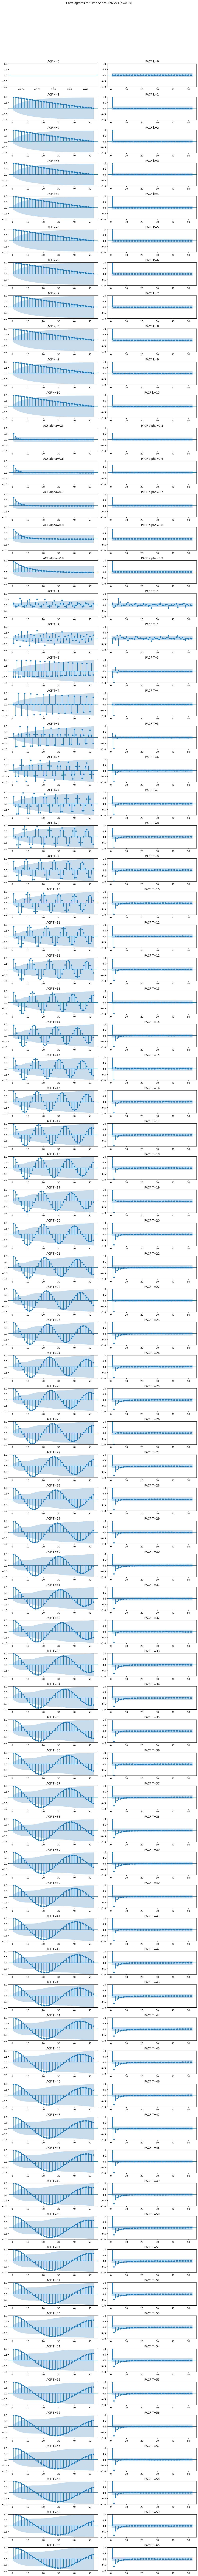

In [ ]:
gd = line_trend + exp_trend + seasonal
analitycs = Analytics(gd.data, title=name)
analitycs.correlogram_compare()
# analitycs.plot_ts()

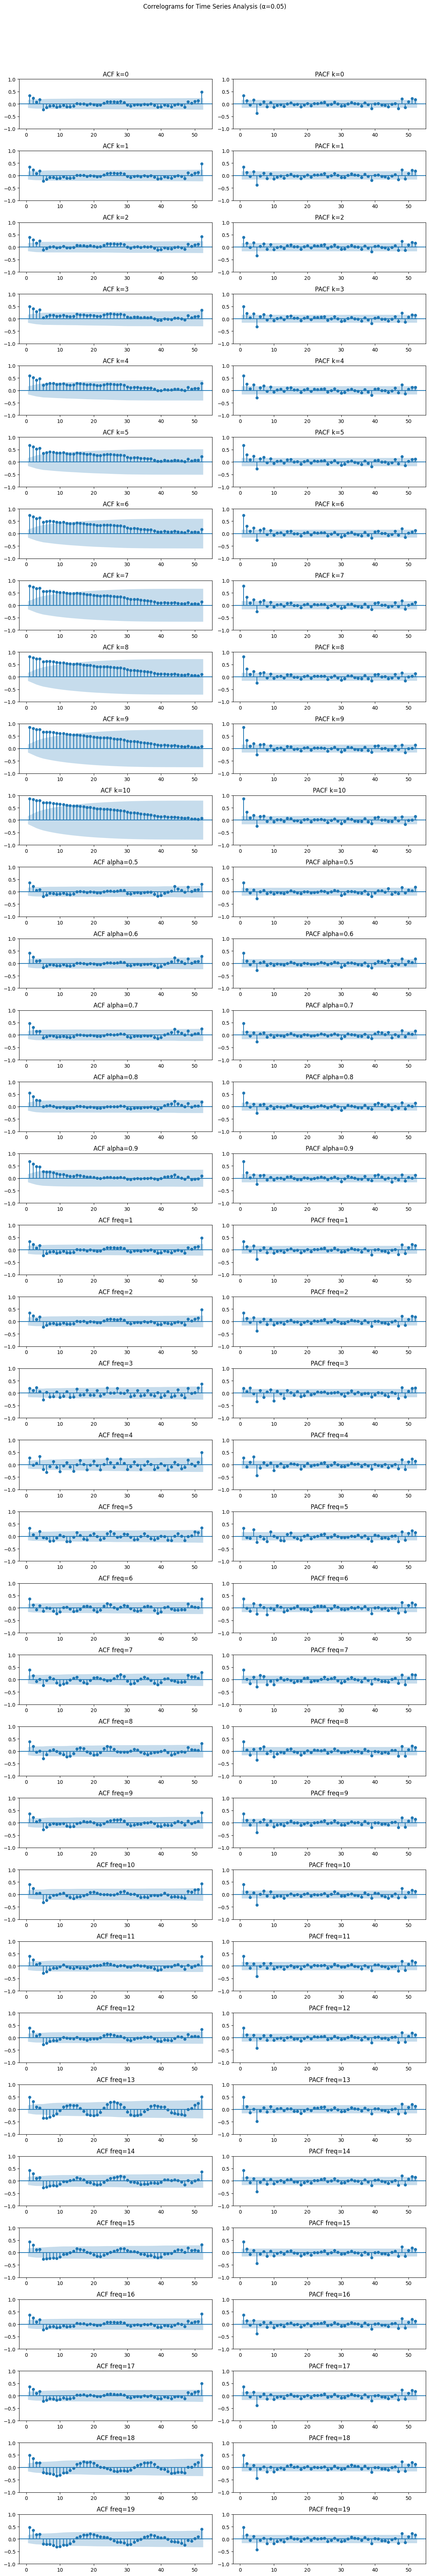

In [ ]:
gd = GenerateData(df.y, line_trend.data) + GenerateData(df.y, exp_trend.data) + GenerateData(df.y, seasonal.data)
analitycs = Analytics(gd.data, title=name)
analitycs.correlogram_compare()

Основная частота: 0.0420 циклов/отсчёт
Соответствует периоду: 23.83 отсчётов


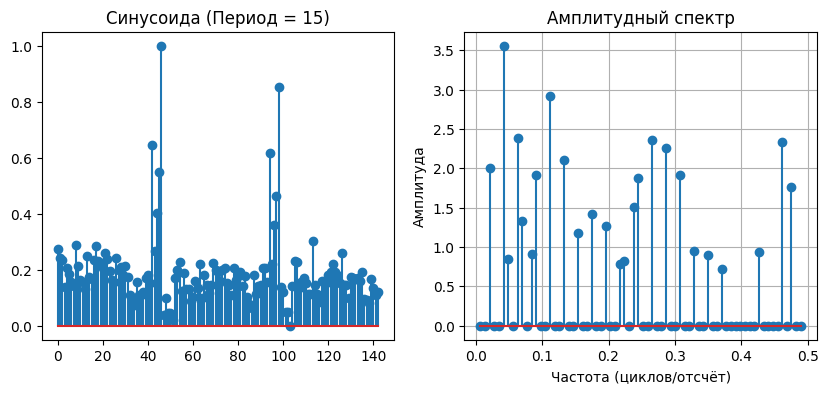

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры сигнала
N = len(df.y)  # Длина массива (желательно кратна 15 для лучшего разрешения)
T = 15  # Период синусоиды
freq = 1 / T  # Частота сигнала

# Генерируем синусоиду
x = np.arange(N)
y = df.y.values #np.sin(2 * np.pi * freq * x)

# Вычисляем ДПФ
fft_result = np.fft.fft(y)
for i in range(len(fft_result)):
  fft_result[i] = 0 if fft_result[i] <= .5 else fft_result[i]
frequencies = np.fft.fftfreq(N)

# Находим индекс максимальной амплитуды (исключая нулевую частоту)
main_freq_index = np.argmax(np.abs(fft_result[1:N//2])) + 1
main_freq = frequencies[main_freq_index]

print(f"Основная частота: {main_freq:.4f} циклов/отсчёт")
print(f"Соответствует периоду: {1/main_freq:.2f} отсчётов")

# График сигнала
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.stem(x, y)
plt.title("Синусоида (Период = 15)")

# График амплитудного спектра
plt.subplot(1, 2, 2)
plt.stem(frequencies[1:N//2], np.abs(fft_result[1:N//2]))
plt.title("Амплитудный спектр")
plt.xlabel("Частота (циклов/отсчёт)")
plt.ylabel("Амплитуда")
plt.grid()
plt.show()

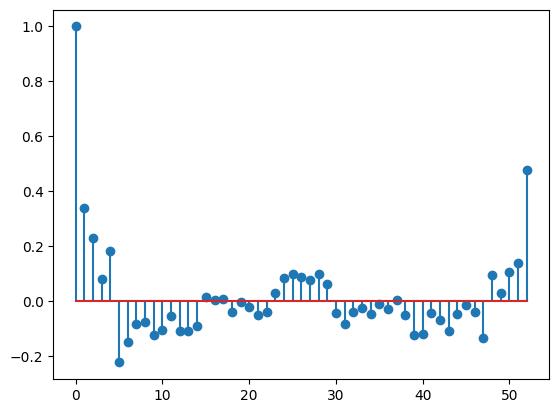

In [ ]:
from statsmodels.tsa.stattools import acf

acf = acf(df.y, nlags=52, fft=False)
plt.stem(np.arange(len(acf)), acf)
plt.show()

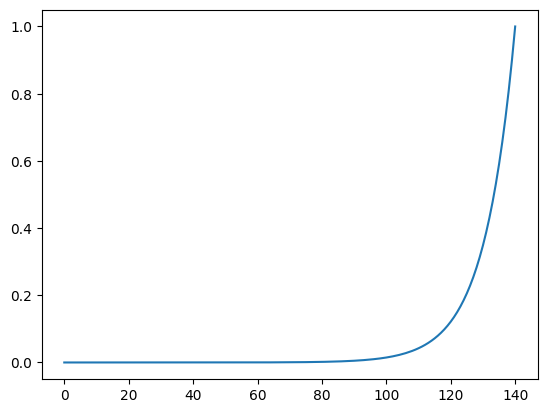

In [ ]:
n = 141  # Количество фолдов
alpha = .9  # Коэффициент убывания

weights = np.array([alpha ** (n - i) for i in range(1, n + 1)])
# weights /= weights.sum()
# weights *= 2

plt.plot(weights)
plt.show()